# Assessment 1 

The goal of this assessment is to create a model submission to predict normal vs non-normal traffic under a given performance metric. The analysis will take place on the [KD99 (small, 10%) data set](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

To begin the assessment, we first need to import the data into our notebook.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import requests

%matplotlib inline
mpl.style.use('ggplot')

## Importing the Training/Test Data Set

In [2]:
df_train = pd.read_csv('kd_train.csv')
df_test = pd.read_csv('kd_test.csv')

In [3]:
df_test.shape

(49402, 43)

In [4]:
print(df_train.shape)
df_train.head()

(444619, 44)


,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,folds
0,44625,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
1,339463,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
2,321570,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
3,355860,0,tcp,private,S0,0,0,0,0,0,...,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.,1
4,9708,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1


## Data Cleansing

From the header, we can see that there is a folds column which wasn't in the original data set and therefore we will drop it.

In [5]:
del df_train['folds']

After running the test on the model the first time, I was getting errors due to the features not matching. Because we perform get_dummies later on in this notebook, we introduce exceptions where some services and flags don't exist within the test data set but do in the training data set and vice versa.

From Data Analysis performed on the code previously, we find that we are missing Service: tftp_u from the training data and Service: X11, pm_dump, red_i, tim_i and Flag: RSTOS0 from the test data. This is understandable as they occur very infrequently as is identified through other data analysis.

To resolve this issue without introducing events that didn't occur within the dataset, we will select events within the respective data sets to add to the events currently contained in each data set to resolve this issue, instead of creating new events which may disrupt the patterns identified.

In [6]:
# getting the tftp_u service event from the test data which isnt in the training data
tftp_u_add = df_test.loc[df_test['service'] == 'tftp_u'] 
print(tftp_u_add)

       Unnamed: 0  duration protocol_type service flag  src_bytes  dst_bytes  \
13529      140585         0           udp  tftp_u   SF          1          0   

       land  wrong_fragment  urgent  ...  dst_host_srv_count  \
13529     0               0       0  ...                   1   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
13529                    0.02                    0.06   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
13529                         0.02                          0.0   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
13529                   0.0                       0.0                   0.0   

       dst_host_srv_rerror_rate    label  
13529                       0.0  normal.  

[1 rows x 43 columns]


In [7]:
# getting the events from the training data which aren't in the test data
X11_add = df_train.loc[df_train['service'] == 'X11']
X11_add = X11_add.loc[X11_add['Unnamed: 0'] == 345610]

pm_dump_add = df_train.loc[df_train['service'] == 'pm_dump']

red_i_add = df_train.loc[df_train['service'] == 'red_i']

tim_i_add = df_train.loc[df_train['service'] == 'tim_i']
tim_i_add = tim_i_add.loc[tim_i_add['Unnamed: 0'] == 458739]

RSTOS0_add = df_train.loc[df_train['flag'] == 'RSTOS0']
RSTOS0_add = RSTOS0_add.loc[RSTOS0_add['Unnamed: 0'] == 42072]

In [8]:
# adding the missing data to the test set
df_test = pd.concat([df_test,X11_add,pm_dump_add,red_i_add,tim_i_add,RSTOS0_add])

In [9]:
# adding the missing data to the training set
df_train = pd.concat([df_train,tftp_u_add])

We now need to remove the unnamed: 0 column as it wasn't in the original data. We will also update the index's to start at 1.

In [10]:
del df_train['Unnamed: 0']

df_train.index += 1

In [11]:
del df_test['Unnamed: 0']

df_test.index += 1

We can now make sure that this has worked by reprinting the headers.

In [12]:
print(df_train.shape)
df_train.head()

(444620, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
3,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
4,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
5,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


In [13]:
print(df_test.shape)
df_test.head()

(49407, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
2,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
3,0,tcp,http,SF,186,21709,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,private,S0,0,0,0,0,0,0,...,18,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
5,0,tcp,http,SF,341,6843,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.


We need to seperate out the response variables and the features to ensure we can use the later models so we will do this here.

In [14]:
df_train_resp = pd.DataFrame(df_train[['label']])
df_train = df_train.drop(labels='label', axis=1)
df_train_resp.head()

,label
1,smurf.
2,smurf.
3,smurf.
4,neptune.
5,smurf.


We need to do the same splitting for the test data.

In [15]:
df_test_resp = pd.DataFrame(df_test[['label']])
df_test = df_test.drop(labels='label', axis=1)
df_test_resp.head()

,label
1,neptune.
2,smurf.
3,normal.
4,neptune.
5,normal.


To allow us to use the data in the mutual information and random forest settings, we need to reclassify the response data. In this case, we need to split the data into normal and non-normal processes and represent them using integers. We will do this for both data sets below.

In [16]:
def labeler(df):
    for i in range(0,len(df)):
    
        if df.iat[i,0] == 'normal.':
            df.iat[i,0] = '0'
        else:
            df.iat[i,0] = '1'

In [17]:
labeler(df_test_resp)
labeler(df_train_resp)

We also need to change all the data to integer/float types to allow it to be processed and we do this below. The get_dummies function was accessed through [3].

In [18]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

df_test_resp = df_test_resp['label'].astype('int32')
df_train_resp = df_train_resp['label'].astype('int32')

In [19]:
df_train_resp.dtypes, df_train.dtypes, df_test_resp.dtypes, df_test.dtypes

(dtype('int32'), duration          int64
 src_bytes         int64
 dst_bytes         int64
 land              int64
 wrong_fragment    int64
                   ...  
 flag_S1           uint8
 flag_S2           uint8
 flag_S3           uint8
 flag_SF           uint8
 flag_SH           uint8
 Length: 118, dtype: object, dtype('int32'), duration          int64
 src_bytes         int64
 dst_bytes         int64
 land              int64
 wrong_fragment    int64
                   ...  
 flag_S1           uint8
 flag_S2           uint8
 flag_S3           uint8
 flag_SF           uint8
 flag_SH           uint8
 Length: 118, dtype: object)

We can see from the above that this process has worked correctly and we now have all factors in terms of integers (using dummy variables).

## Data Analysis

In [20]:
df_train['duration'].describe()

count    444620.000000
mean         47.712944
std         708.552082
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       58329.000000
Name: duration, dtype: float64

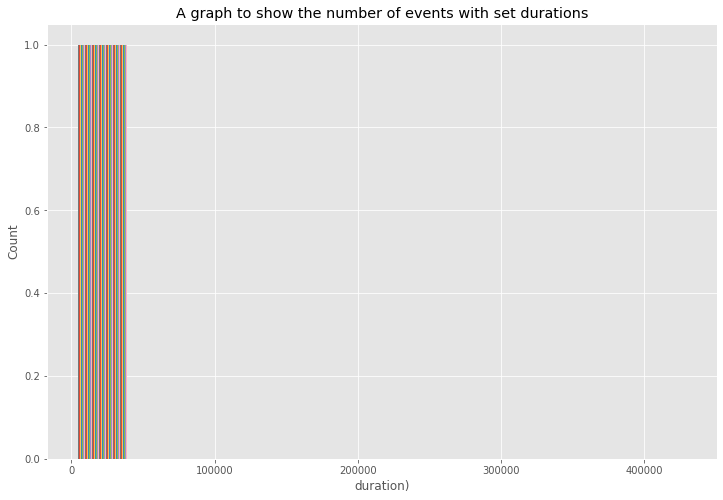

In [21]:
# Histogram of durations 
durations = pd.DataFrame(df_train.groupby('duration').size().sort_values(ascending=False))

plt.figure(figsize=(12,8))
plt.hist(durations)
plt.xlabel('duration)')
plt.ylabel('Count')
plt.title('A graph to show the number of events with set durations')
plt.show()

## Mutual Information

According to the sklearn User Guide, "mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation." We have 444,619 training samples, so mutual information should work well. Because the target variable is discrete, we use mutual_info_classif (as opposed to mutual_info_regression for a continuous target). Mutual information of 0 indicates no dependence, and higher values indicate higher dependence. 

In [22]:
from sklearn.feature_selection import mutual_info_classif

In [23]:
data=mutual_info_classif(df_train, df_train_resp, discrete_features=False, random_state=1)

In [24]:
mutual_infos = pd.Series(data,index= df_train.columns)

In [25]:
mutual_infos.sort_values(ascending=False)

src_bytes                      0.455964
count                          0.452685
dst_bytes                      0.369601
dst_host_same_src_port_rate    0.301272
srv_count                      0.267770
                                 ...   
service_vmnet                  0.000000
service_whois                  0.000000
rerror_rate                    0.000000
service_daytime                0.000000
service_remote_job             0.000000
Length: 118, dtype: float64

The five most correlated variables with normal/non-normal data are, in decreasing order, src_bytes, count, dst_bytes, dst_host_same_src_port_rate & srv_count.

## Random Forest

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef

In [27]:
MCC_scorer = make_scorer(matthews_corrcoef)

In [28]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes much longer to train on this fairly large dataset, so we don't actually do a hyperparameter grid search, only specifiying the number of estimators. We'll leave the grid search implemented in case we decide to try different hyperparameter values in the future.

In [29]:
param_grid_rf = {'model__n_estimators': [75]}

In [30]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [31]:
grid_rf.fit(df_train, df_train_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [32]:
grid_rf.best_score_

0.9994240914003581

In [33]:
grid_rf.best_params_

{'model__n_estimators': 75}

## Test Set Evaluation of the Best Model

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [35]:
def classification_eval(estimator,df_test,df_test_resp):
    y_pred=estimator.predict(df_test)
    dec = np.int64(np.ceil(np.log10(len(df_test_resp))))
    
    print("Confusion Matrix")
    print(confusion_matrix(df_test_resp,y_pred),'\n')
    
    print('Classification report')
    print(classification_report(df_test_resp, y_pred, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(df_test_resp, y_pred)))
    
    if df_test_resp.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(df_test)[:,1]
        except:
            y_score = estimator.decision_function(df_test)
        print(format_str % ('AUPRC', average_precision_score(df_test_resp, y_score)))
        print(format_str % ('AUROC', roc_auc_score(df_test_resp, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(df_test_resp, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(df_test_resp, y_pred)))

In [36]:
classification_eval(grid_rf, df_test, df_test_resp)

Confusion Matrix
[[ 9731     0]
 [    3 39673]] 

Classification report
              precision    recall  f1-score   support

           0    0.99969   1.00000   0.99985      9731
           1    1.00000   0.99992   0.99996     39676

    accuracy                        0.99994     49407
   macro avg    0.99985   0.99996   0.99990     49407
weighted avg    0.99994   0.99994   0.99994     49407

Scalar Metrics
          MCC = 0.99981
        AUPRC = 1.00000
        AUROC = 1.00000
Cohen's kappa = 0.99981
     Accuracy = 0.99994


According to the MCC, the random forest performed better on the test set than on the training set. This is probably due to the refit model being trained on the entire training data set, and not on the smaller CV folds.

We can also see from the Confusion matrix that there were 3 events that were false negatives and were therefore predicted to be normal but were actually non-normal events. After performing some analysis, two of these were smurf attacks and one of them was a neptune attack. 

The two smurf attacks, event 6054 and 13077 had exactly the same factors as each other. When analysing the two attacks that weren't predited by the model, we find that both of them have the same values as the median of all the other smurf attacks and thus I'm not sure why they weren't identified when others were. On the other hand, this is a $$ 2/28200 = 0.00007 $$ failure rate and thus is negligible.

The neptune attack was event 47418. Similarly to the smurf attacks, the factors of this model had values that were within the median-75% quartile of this attack and thus I'm not sure why it wasn't identified when other were. On the other hand, this is a $$ 1/10603 = 0.00009 $$ failure rate and thus is negligible.

## Conclusion

We were able to accurately identify non-normal vs normal traffic using the Random Forest model. We found that he five most correlated variables with normal/non-normal data are, in decreasing order, src_bytes, count, dst_bytes, dst_host_same_src_port_rate & srv_count. We had to perform some data manupulation before running the models which included:
1. Getting rid of unwanted columns.
2. Adding in events to each data set to ensure we covered all factors in both data sets.
3. Ensuring all data was in integer format by using dummie variables.

We used the Matthews correlation coefficient (MCC) to review the performance of the model. In cross validation, the Random Forest achieved a cross-validated MCC score of 0.999 with 3 false-negatives.

## References

1. [Source of data](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
2. [Source of headers for the data table](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names)
3. [How to create dummy variables](https://stackoverflow.com/questions/40643831/value-error-could-not-convert-string-to-float-while-using-sklearn-feature-relev)
4. [Information regarding sklearn.mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)
5. [Information regarding sklearn.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
6. [Credit Card Fraud Analysis which introduced me to Random Forest](https://www.kaggle.com/guptanandita/kernel7a055de514)
7. [Information regarding sklearn.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)